# ✨ 1. 데이터 수집 (수집된 데이터 확인)

### 필요 모듈 설치

In [2]:
# 필요 모듈 설치
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, GRU, SimpleRNN, Dropout
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

### 코드깨짐 방지

In [3]:
# 코드깨짐 방지 (폰트를 해당 파일 위치와 같은 곳에 깔아두고, 아래 코드 실행)
from matplotlib import font_manager, rc
font_path = './malgun.ttf' # 폰트 파일 위치
font_name = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font_name)

In [4]:
# 데이터 불러오기
df = pd.read_csv('./racoi_real.csv', encoding='cp949')

In [5]:
df.head(3)

,date,rating,episode,holiday,holiday(inform),before,after,시청자버즈(게시글),시청자버즈(댓글),시청자버즈(동영상조회),미디어버즈(뉴스),미디어버즈(동영상),기온,강수량,풍속,습도,적설
0,2017.5.7,6.3,349,0,NaN,1.2,5.6,254,1677,531883,134,10,21.416039,0.0,4.234449,25.135210,0.0
1,2017.5.14,6.6,350,0,NaN,1.3,8.1,314,1957,346255,114,10,19.166496,0.0,4.273570,36.637672,0.0
2,2017.5.21,5.9,351,0,NaN,1.0,6.2,323,1781,296029,225,10,24.545663,0.0,2.751687,40.961533,0.0


### 데이터 양 파악

In [6]:
df.shape

(256, 17)

### 피처 이해

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             256 non-null    object 
 1   rating           256 non-null    float64
 2   episode          256 non-null    int64  
 3   holiday          256 non-null    int64  
 4   holiday(inform)  7 non-null      object 
 5   before           256 non-null    float64
 6   after            256 non-null    float64
 7   시청자버즈(게시글)       256 non-null    int64  
 8   시청자버즈(댓글)        256 non-null    int64  
 9   시청자버즈(동영상조회)     256 non-null    int64  
 10  미디어버즈(뉴스)        256 non-null    int64  
 11  미디어버즈(동영상)       256 non-null    int64  
 12  기온               256 non-null    float64
 13  강수량              256 non-null    float64
 14  풍속               256 non-null    float64
 15  습도               256 non-null    float64
 16  적설               256 non-null    float64
dtypes: float64(8), i

=> date의 자료형을 datetime으로 변환 후 년도, 월, 계절, 상반기/하반기 변수 추가<br>
=> episode, holiday(inform) 변수 제거<br>
=> 소수 형태 데이터 반올림 첫째자리까지<br>
=> after 결측값 : 4개는 평균으로 대체, 2021년 8월 8일은 도쿄 올림픽 폐막식 중계 3.6%<br>
=> 버즈 결측값 : 임의로 평균으로 대체

### 효과적인 시각화를 위한 피처 엔지니어링

In [8]:
# date 변수 변환 및 인덱스 설정
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year # 년도 변수 생성
df['month'] = df['date'].dt.month # 월 변수 생성
df.set_index('date', inplace = True)

In [9]:
# 불필요한 변수 제거 ('episode', 'holiday(inform)')
df.drop(['holiday(inform)', 'episode'], axis = 1, inplace = True)

In [10]:
# 소수 형태 데이터 반올림
float_columns = df.dtypes[df.dtypes == 'float64'].index.values

for i in float_columns:
    df[i] = np.round(df[i], 1)

In [11]:
# before, after 결측값 대체 => 엑셀 파일 내에서 대체하였음 !
# df.loc['2019-11-17', 'after'] = 14.3 # wbsc 프리미어 12 한일전
# df.loc['2021-08-08', 'after'] = 3.6 # 도쿄 올림픽 폐회식 시청률
# df = df.fillna(df.mean()) # 이 외의 결측치 변수 평균값으로 대체
# df.isnull().sum()

# ✨ 2. 탐색적 데이터 분석(EDA)

### 타깃 시각화

* 전체 시청률 추이

* 멤버 교체 요인, PD 교체, 콘텐츠 요인 등을 전반적으로 확인할 예정<br>

* 멤버 교체
 * 2010.8.22: 송지효 합류
 * 2010.11.28: 리지 합류
 * 2011.1.16: 리지 하차
 * 2011.5.8: 송중기 하차
 * 2016.11.13: 개리 하차
 * 2017.4.16: 양세찬, 전소민 합류
 * 2021.6.20: 이광수 하차
 
* PD 교체
 * 1기
   * 조효진 (10년 중순 ~ 14년 중순) : 상승, 전성, 안정
   * 임형택 (14년 중순 ~ 16년 초중순) : 침체, 하락세
 * 2기
   * 3인 PD 체제 (16년 중순 ~ 17년 초중순) : 암흑기, 수습기
   * 정철민 (17년 중순 ~ 18년 중순) : 중흥기
   * 이환진 (18년 말 ~ 19년 중순) : 침체기
   * 정철민 PD 복귀 (19년 중순 ~ 20년 초) : 안정기
 * 3기
   * 최보필 체제 (20년 초 ~ 현재) : 과도기, 상승세, 위기, 극복

In [1]:
# 시청률 데이터 시각화
# 활용 데이터는 런닝맨 전체 년도 시청률 데이터

df_vis = pd.read_csv('./rm_total_for_visualization.csv', encoding='cp949')
df_vis['date'] = pd.to_datetime(df_vis['date'])
df_vis.set_index('date', inplace = True)

plt.figure(figsize=(16, 9))

plt.title("rating plot")
sns.lineplot(y=df_vis['rating'], x=df_vis.index, label = "시청률")
plt.xlabel('time')
plt.ylabel('rating')
plt.grid()
plt.show()

NameError: name 'pd' is not defined

* 주요 시청률 변화
 * 2011년 초 동시간대 프로그램(나는 가수다)으로 인해 시청률이 떨어짐 -> 동시간대 프로그램 시청률에 영향을 많이 받음을 알 수 있음
 * 2011년 말 해외(태국) 특집으로 인해 화제성이 상승하여 시청률이 상승하였으며, 2013년 초부터 콘텐츠의 진부함으로 인해 시청률이 떨어짐 -> 콘텐츠가 시청률에 영향을 많이 받음을 알 수 있음
 * 2014년에는 주요 스태프가 빠지게 되면서 기존의 문제점들이 개선되지 않고 시청률이 지속적 하락 -> PD, 작가 등 스태프에 시청률이 영향을 많이 받음을 알 수 있음<br>
=> 결과적으로 시청률 상승과 하락의 주요 요인에는 콘텐츠와 스태프 변화에 영향을 많이 받았음을 알 수 있음 

* 시청률 요인 분해

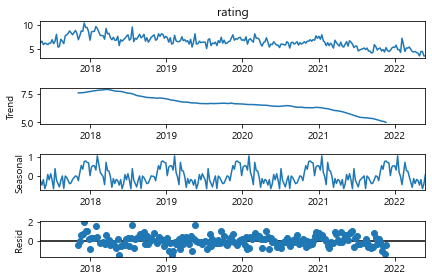

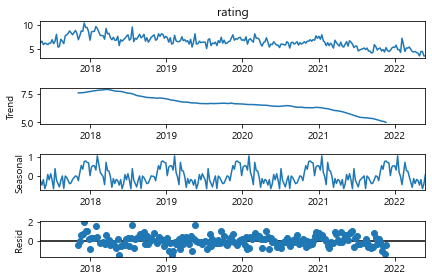

In [13]:
# 시청률 요인 분해 (시계열 데이터 요인 분해)
import statsmodels.tsa.api as tsa
model_series = tsa.seasonal_decompose(df['rating'], model = 'addictive', freq = 50)
# 시청률 데이터 일정하지 않아 addictive, freq = 50으로 1년 주기
model_series.plot()

=> trend을 보면 전체적으로 감소하는 추세<br>
=> seasonal을 보면 계절적 요인을 확인 가능<br>

### 범주형 데이터 시각화 

* holiday

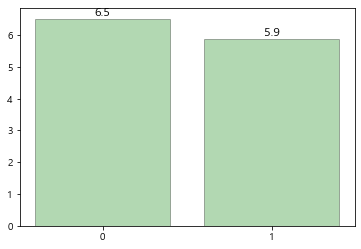

In [15]:
# holiday에 따른 시청률 시각화
holiday_rating = df.groupby('holiday').mean()['rating']
bar = plt.bar(['0', '1'], holiday_rating.values, color = 'green', alpha = 0.3, edgecolor = 'black') # 0이 공휴일 아님, 1이 공휴일

# 시청률 텍스트 추가
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)

plt.show()

=> 공휴일일 때 시청률 평균이 조금 더 낮다<br>
=> 공휴일일 때 사람들의 외출으로 인해 시청률이 더 낮다

* year

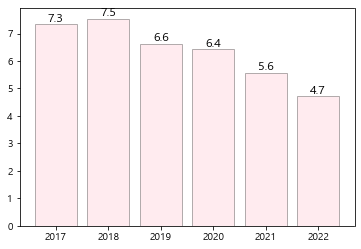

In [16]:
# year에 따른 시청률 시각화 (+ 여기에 상/하반기 추가해서 같이 봐도 괜찮을 듯 !)
year_rating = df.groupby('year').mean()['rating']
bar = plt.bar(year_rating.index, year_rating.values, color = 'pink', alpha = 0.3, edgecolor = 'black')

# 시청률 텍스트 추가
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)

plt.show()

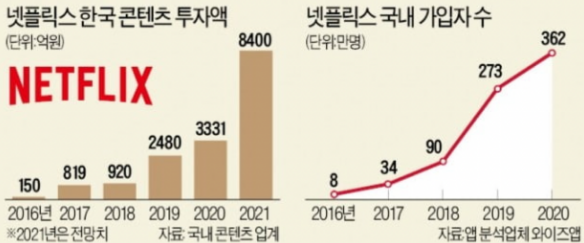<br>
=> 2019년 기획력 부족으로 인해 시청률 하락 & 런닝맨 외에도 전체적인 예능 시청률 하락<br>
=> OTT 및 유튜브의 발달로 인해 TV로 본방송을 챙겨보는 사람수가 줄어 시청률 하락<br>

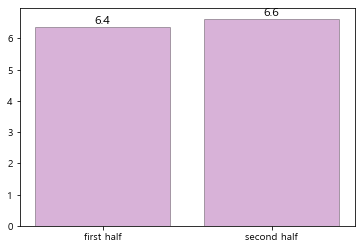

In [17]:
# 상/하반기에 따른 평균 시청률 시각화

# 상/하반기 함수 생성
def func_halfOfYear(x): # 1~6월은 상반기, 7~12월은 하반기
    if x>=1 and x<=6:
        return "first half"
    elif x>=7 and x<=12:
        return "second half"

# 상/하반기 열 데이터 생성
df['half year']=df['month'].apply(lambda x: func_halfOfYear(x))

# 상/하반기에 따른 평균 시청률
half_rating=df.groupby(['half year'])['rating'].mean()

bar=plt.bar(half_rating.index, half_rating.values, color = 'purple', alpha = 0.3, edgecolor = 'black')

# 시청률 텍스트 추가
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)

plt.show()

=> 상반기 보다는 하반기에 평균 시청률이 높다

* season

In [19]:
# 계절에 따른 평균 시청률 시각화

# 계절 함수 생성
def func_season(x): # 3~5월은 봄, 6~8월은 여름, 9~11월은 가을, 1~2월은 겨울로 설정
    if x==3 or x==4 or x==5:
        return "spring"
    elif x==6 or x==7 or x==8:
        return "summer"
    elif x==9 or x==10 or x==11:
        return "fall"
    elif x==12 or x==1 or x==2:
        return "winter"

# 계절에 따른 시청률
df['season']=df['month'].apply(lambda x : func_season(x))

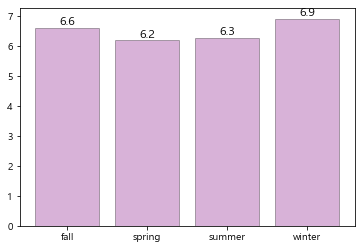

In [22]:
df['month']=df.index.month
season_rating=df.groupby(['season'])['rating'].mean()
bar=plt.bar(season_rating.index, season_rating.values, color = 'purple', alpha = 0.3, edgecolor = 'black')
# print('spring:',season_rating['spring'])
# print('summer:',season_rating['summer'])
# print('fall:',season_rating['fall'])
# print('winter:',season_rating['winter'])

# 시청률 텍스트 추가
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)

plt.show()

=> 시청률 평균은 봄에 가장 낮고, 겨울에 가장 높다<br>
=> 날씨가 좋은 봄에 외출이 많아 시청률이 낮다<br>
=> 겨울은 날씨가 추워 집에서 머무르는 시간이 많아 시청률이 높다

* month

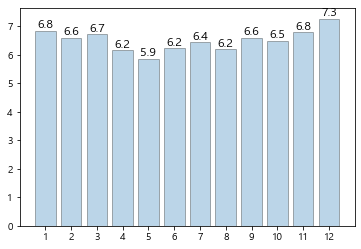

In [23]:
# 월별 평균 시청률 시각화

month_rating=df.groupby(['month'])['rating'].mean()
bar=plt.bar(['1','2','3','4','5','6','7','8','9','10','11','12'], month_rating.values, alpha = 0.3, edgecolor = 'black')

# 시청률 텍스트 추가
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)

plt.show()

=> 시청률이 5월에 가장 낮고, 12월에 가장 높다<br>
-> 5월은 가정의 달로 인해 어린이날, 어버이날, 스승의 날, 성년의 날, 부부의 날 등 가족과 관련된 기념일이 많아 외출에 증가로 인해 시청률이 낮다<br>

### 데이터 관계 시각화

* 히트맵

<AxesSubplot:>

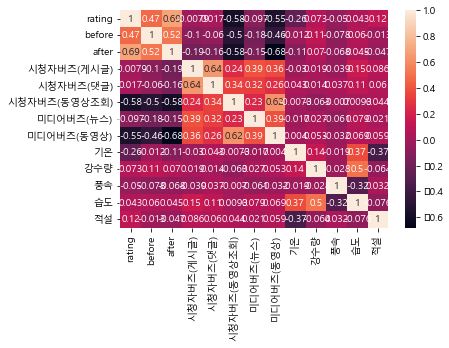

In [24]:
# 히트맵
df_corr = df.drop(['holiday', 'year', 'month'], axis = 1) # 필요없는 열 제거
corr = df_corr.corr() # 상관행렬 
sns.heatmap(corr, annot = True)

=> 시청률과 상관관계를 나타내는 변수는 런닝맨 이후 시청률, 동영상과 관련된 시청자 버즈, 미디어 버즈<br>
=> 런닝맨 이후 시청률은 시청률과 양의 상관관계로, 런닝맨 이후 방송을 보기 위해 런닝맨을 시청하는 사람들이 있다고 판단<br>
=> 동영상 버즈는 시청률과 음의 상관관계로, 동영상 버즈가 긍정적인 영향보다는 멤버 및 프로그램의 사건, 사고와 관련된 부정적인 영향이 있다고 판단<br>
=> 버즈량을 나타내는 변수끼리 상관관계가 높아 다중공선성 문제 우려<br>
=> 버즈량끼리 크기 차이가 많이 나기 때문에 정규화 후 이를 평균 낸 통합변수 고려<br>

* 성별 / 나이대별 시청률 차이 (=> 년도별)

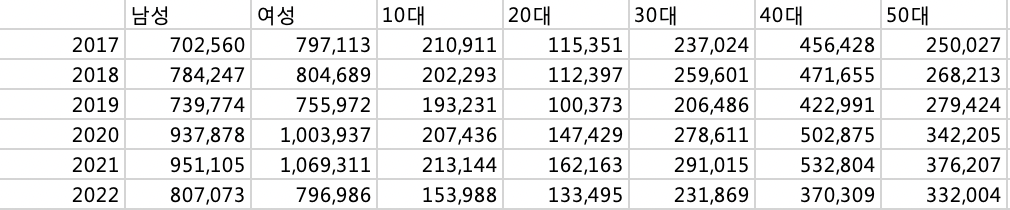

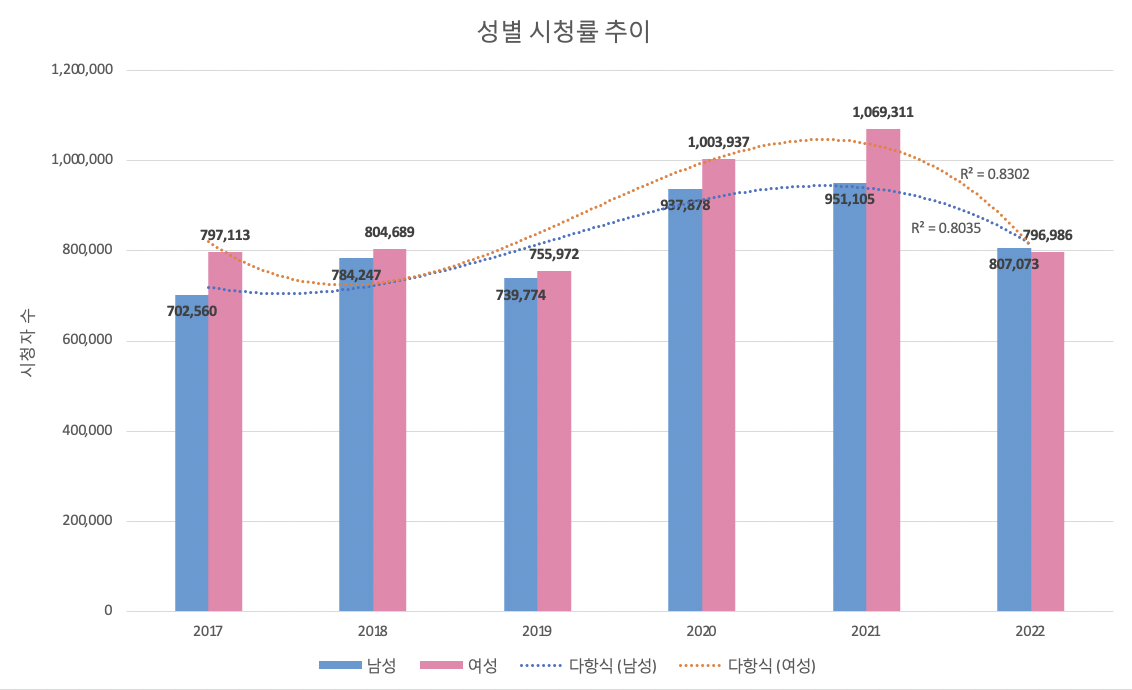

=> 남성보다 여성의 시청자수(시청률)가 높다<br>
=> 여성을 타겟으로 하는 광고의 노출 ↑

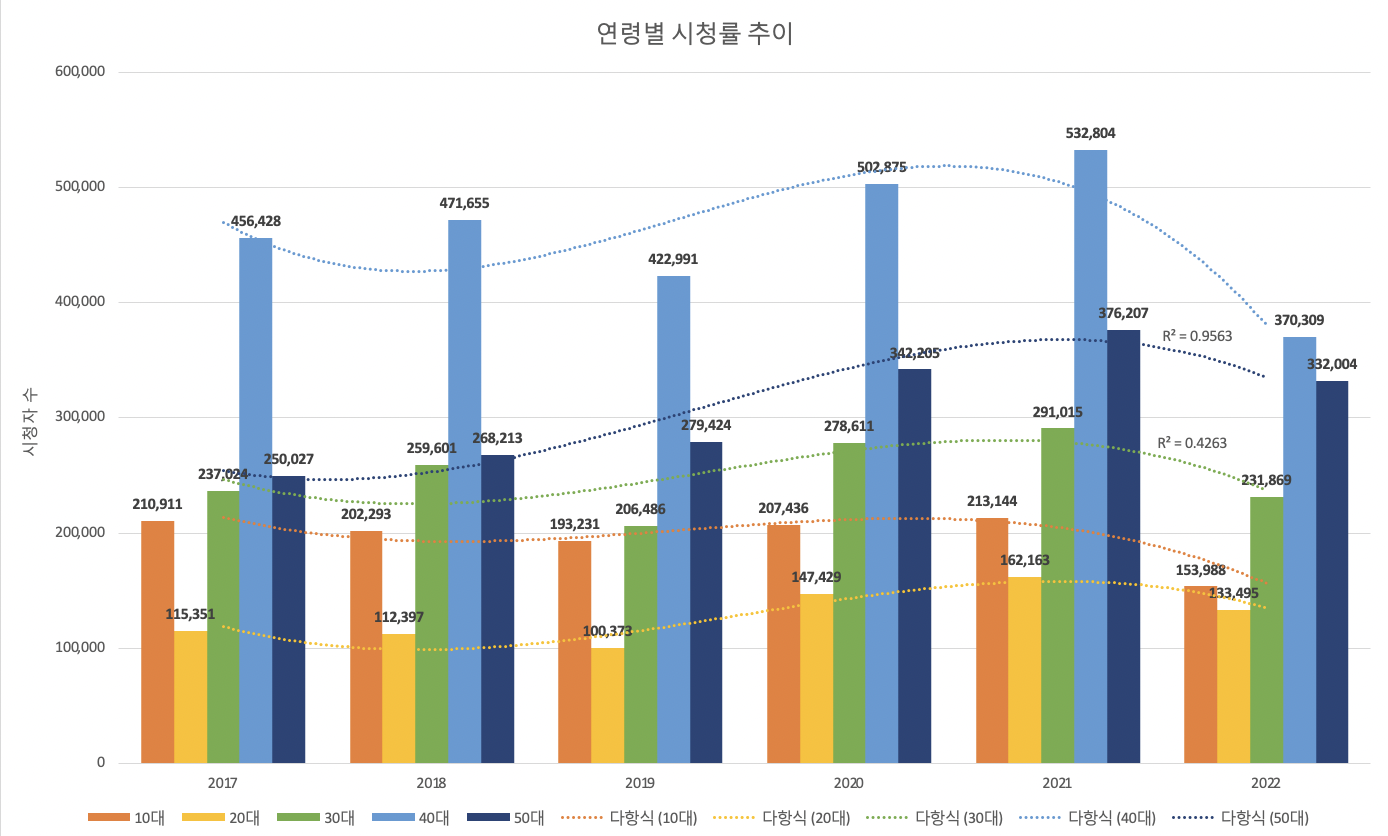

=> 전반적으로 40대의 시청자수(시청률)이 높고, 50대의 시청자수(시청률)이 그 뒤를 따른다<br>
=> 중장년층을 타겟으로 하는 광고 노출 ↑

# ✨ 3. 데이터 전처리

* 결측치 대체
 * before, after 변수에서 특집방송으로 인한 시청률 결측치 직접 찾아 엑셀에서 대체
 * before, after 변수에서 결방으로 인한 시청률 평균으로 대체

* 데이터 분포 변환
 * minmax scaler 적용
 * 변환과 함께 통합버즈 생성 후 히트맵 확인

In [25]:
# 피처값 스케일링
scaler1 = MinMaxScaler()
scaled_feature_df = scaler1.fit_transform(df.drop(['rating', 'holiday', 'year', 'month', 'half year', 'season'], axis = 1))
scaled_feature_df = pd.DataFrame(scaled_feature_df, columns = ['before', 'after', '시청자버즈(게시글)', 
                                                               '시청자버즈(댓글)', '시청자버즈(동영상조회)', 
                                                               '미디어버즈(뉴스)', '미디어버즈(동영상)', 
                                                               '기온', '강수량', '풍속', '습도', '적설'])

# 라벨값 스케일링
scaler2 = MinMaxScaler()
scaled_label_df = scaler2.fit_transform(df['rating'].values.reshape(-1,1))
scaled_label_df = pd.DataFrame(scaled_label_df, columns = ['rating'])

In [26]:
# holiday 변수 다시 붙이기
df['holiday'].index = list(range(0, 256))
scaled_feature_df= pd.concat([scaled_feature_df, df['holiday']], axis = 1)

<AxesSubplot:>

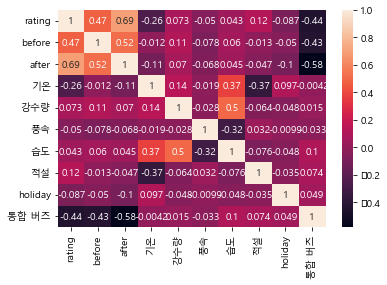

In [27]:
# 통합버즈 생성
scaled_feature_df['통합 버즈'] = (scaled_feature_df['시청자버즈(게시글)'] + scaled_feature_df['시청자버즈(댓글)'] + scaled_feature_df['시청자버즈(동영상조회)'] + scaled_feature_df['미디어버즈(뉴스)'] + scaled_feature_df['미디어버즈(동영상)']) / 5
scaled_feature_df.drop(['시청자버즈(게시글)', '시청자버즈(댓글)', '시청자버즈(동영상조회)', '미디어버즈(뉴스)', '미디어버즈(동영상)'], axis = 1, inplace = True)
df_corr = pd.concat([scaled_label_df, scaled_feature_df], axis = 1)
corr = df_corr.corr()
sns.heatmap(corr, annot = True)

=> 버즈량 변수에서의 다중공선성 문제 해결 완료

* 이상치 제거
 * 타깃값과 상관성이 높은 변수의 이상치 제거
 * 타깃값과 가장 상관성이 높은 변수인 after의 이상치 제거

In [28]:
import numpy as np

# 이상치 제거하는 함수
def get_outlier(df = None, column = None, weight = 1.5):
    # 1/4분위와 3/4분위 지점을 np.percentile로 구함
    after = df['after']
    quantile_25 = np.percentile(after.values, 25)
    quantile_75 = np.percentile(after.values, 75)
    # IQR을 구하고, IQR에 1.5를 곱해 최대, 최소값 지점 구함
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    # 최댓값보다 크거나, 최솟값보다 작은 값을 이상치 데이터로 설정하고 데이터프레임 index 반환
    outlier_index = after[(after < lowest_val) | (after > highest_val)].index
    return outlier_index

In [29]:
# 이상치 제거 함수 적용
outlier_index = get_outlier(df = df_corr, column = 'after', weight = 1.5)
print(outlier_index) # 127번 인덱스를 가진 데이터 삭제

Int64Index([127], dtype='int64')


In [31]:
# 이상치 값인 127번째 행 제거
df = df_corr.drop(outlier_index, axis = 0)

# ✨ 4. 모델링 

### 최종 데이터 불러오기

In [32]:
df = df_corr

### 학습 / 테스트 데이터 나누기

In [33]:
window_size = 20
TEST_SIZE = int(len(df) * 0.7)

train = df[:TEST_SIZE]
test = df[TEST_SIZE:]

In [34]:
# 데이터셋을 만들어 주는 함수
# window_size 기준으로 데이터셋 생성

def make_dataset(feature, label, window_size = 20):
  
  feature_list = [] # feature들을 저장할 리스트 생성 및 초기화
  label_list = [] # label 값들을 저장할 리스트 생성 및 초기화

# 설정한 윈도우 사이즈만큼 feature, label을 묶기 위한 for문
  for i in range(len(feature) - window_size) :
    # 20개의 feature를 하나로 묶어 feature list에 저장
    feature_list.append(feature.iloc[i:i+window_size])
    # 20개의 label을 하나로 묶어 label list에 저장
    label_list.append(label.iloc[i+window_size])
  
  return np.array(feature_list), np.array(label_list)

### 변수 선택 및 데이터 나누기

In [35]:
# 피처 변수
feature_cols = ['before', 'after', '기온', '강수량', '풍속', '습도', '적설', 'holiday', '통합 버즈']
# 라벨 변수
label_cols = ['rating']

# train 데이터 생성
train_feature = train[feature_cols]
train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)

# early stopping을 위한 valid 데이터 생성
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2, shuffle = False)
x_train.shape, x_valid.shape

# test 데이터 생성
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature , test_label = make_dataset(test_feature, test_label,20)

### 모델 생성 및 훈련

In [36]:
# 모델 검증을 위해 for문을 이용해 학습 / 검증을 3번 반복해 구한 평균 RMSE로 성능 비교

result = []

for i in range(3):
    # 순차적으로 레이어 층을 더해주는 순차모델 생성
    model = Sequential()
    # 64개의 노드를 가지고 활성화 함수를 relu로 하는 RNN모델을 레이어에 추가
    model.add(SimpleRNN(64, 
                   input_shape=(train_feature.shape[1], train_feature.shape[2]), 
                   activation='relu'))
    # 1개의 출력을 생성하는 노드 1의 Dense모델을 레이어에 추가
    model.add(Dense(1)) # output이 1개이기 때문에 dense = 1

    #실제 연속적인 값을 예측하는 것이기 때문에 loss function은 mse
    # 일반적으로 optimizer은 adam 주로 사용, 학습률은 실험을 통해 나온 최적값인 0.0001 사용
    model.compile(loss='mean_squared_error',
                  optimizer= Adam(lr = 0.0001))

    #10회 Epoch동안 개선되지 않는다면 종료
    early_stop = EarlyStopping(monitor='val_loss', patience=10)

    model_path = 'model'
    filename = os.path.join(model_path, 'tmp_checkpoint.h5')
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

    # fit함수로 모델을 학습시킴, 최대 200번 학습하며 10개의 샘플 단위마다 모델의 가중치를 한번씩 업데이트 함
    # 검증데이터는 모델 평가에 사용
    # callbacks 함수는 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체
    # early stop은 과대 적합을 예방하기 위해 훈련을 조기종료하는 것
    # checkpoint는 최상의 검증 점수를 만드는 모델을 저장하는 것
    history = model.fit(x_train, y_train, 
                                    epochs= 400, 
                                    batch_size= 5,
                                    validation_data=(x_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint])
    
    model.load_weights(filename)
    
    # 학습한 모델을 통해 test feature로 예측해 나온 결과인 label들을 pred에 저장
    pred = model.predict(test_feature)
    
    # 0~1 사이의 값으로 스케일링된 값들을 역변환하여 원래 값으로 복원
    rescaled_y_true = scaler2.inverse_transform(np.array(test_label).reshape(-1, 1))
    rescaled_pred = scaler2.inverse_transform(np.array(pred).reshape(-1,1))
    
    RMSE = np.sqrt(mean_squared_error(rescaled_y_true, rescaled_pred)) # RMSE 계산
    result.append(RMSE) # result에 RMSE 추가
    
np.mean(result) # 평균 RMSE 도출

Epoch 1/400
21/26 [=======================>......] - ETA: 0s - loss: 0.1921
Epoch 1: val_loss improved from inf to 0.05763, saving model to model\tmp_checkpoint.h5
26/26 [==============================] - 2s 20ms/step - loss: 0.1781 - val_loss: 0.0576
Epoch 2/400
20/26 [======================>.......] - ETA: 0s - loss: 0.1060
Epoch 2: val_loss improved from 0.05763 to 0.02106, saving model to model\tmp_checkpoint.h5
26/26 [==============================] - 0s 8ms/step - loss: 0.1007 - val_loss: 0.0211
Epoch 3/400
21/26 [=======================>......] - ETA: 0s - loss: 0.0614
Epoch 3: val_loss improved from 0.02106 to 0.01137, saving model to model\tmp_checkpoint.h5
26/26 [==============================] - 0s 8ms/step - loss: 0.0586 - val_loss: 0.0114
Epoch 4/400
20/26 [======================>.......] - ETA: 0s - loss: 0.0420
Epoch 4: val_loss did not improve from 0.01137
26/26 [==============================] - 0s 7ms/step - loss: 0.0391 - val_loss: 0.0147
Epoch 5/400
19/26 [=========

Epoch 11/400
22/26 [========================>.....] - ETA: 0s - loss: 0.0302
Epoch 11: val_loss improved from 0.04216 to 0.03753, saving model to model\tmp_checkpoint.h5
26/26 [==============================] - 0s 8ms/step - loss: 0.0299 - val_loss: 0.0375
Epoch 12/400
22/26 [========================>.....] - ETA: 0s - loss: 0.0276
Epoch 12: val_loss did not improve from 0.03753
26/26 [==============================] - 0s 7ms/step - loss: 0.0270 - val_loss: 0.0498
Epoch 13/400
20/26 [======================>.......] - ETA: 0s - loss: 0.0245
Epoch 13: val_loss did not improve from 0.03753
26/26 [==============================] - 0s 7ms/step - loss: 0.0249 - val_loss: 0.0429
Epoch 14/400
20/26 [======================>.......] - ETA: 0s - loss: 0.0242
Epoch 14: val_loss improved from 0.03753 to 0.03257, saving model to model\tmp_checkpoint.h5
26/26 [==============================] - 0s 9ms/step - loss: 0.0221 - val_loss: 0.0326
Epoch 15/400
21/26 [=======================>......] - ETA: 0s 

1.1286510451347824

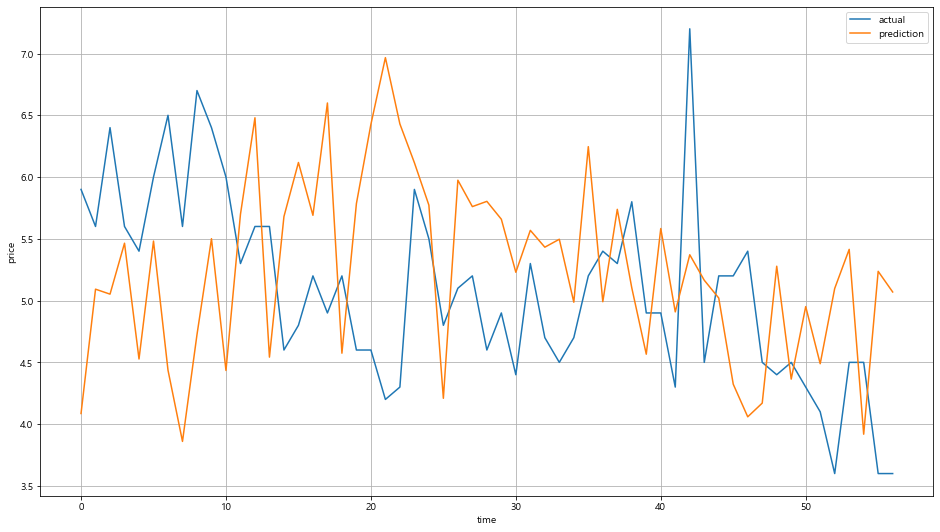

In [37]:
# 실제값과 예측값 비교 (마지막 값 이용)
plt.figure(figsize = (16,9))
plt.xlabel("time")
plt.ylabel("price")
plt.plot(rescaled_y_true, label="actual")
plt.plot(rescaled_pred, label="prediction")
plt.grid()
plt.legend(loc="best")
plt.show()

# ✨ 5. 성능개선

* 피처 셀렉션
 * feature_cols 조정해 각 모델별 성능 비교

* 하이퍼파라미터 최적화
 * 모델 생성 및 훈련에서 각 하이퍼파리미터 조정 후 비교